In [1]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact, fixed, ToggleButtons, IntSlider, FloatSlider
%matplotlib inline

# Define model (adjusted from IN's)

In [53]:
def model_afgeleiden(variables, t, beta, gamma):

    S = variables[0]
    I = variables[1]
    R = variables[2]
    
    S_new = -beta*I*S 
    I_new = beta*I*S - gamma*I
    R_new = gamma*I
    return [S_new, I_new, R_new]

def SIRmodel(tijdstappen, S_0, I_0, R_0, beta, gamma, returnDataFrame=True, plotFig=True):
    """
    Modelimplementatie van het populatiemodel 
    
    Parameters
    -----------
    tijdstappen : np.array
        array van tijdstappen          
    """
    modeloutput = odeint(model_afgeleiden, [S_0, I_0, R_0], tijdstappen, args=(beta, gamma));
    modeloutput = pd.DataFrame(modeloutput, columns=['S','I','R'], index=tijdstappen)
    
    modeloutput.index = pd.date_range(start='11/1/2019', periods=len(tijdstappen))
    
    if plotFig:
        modeloutput.plot()
    if returnDataFrame:
        return modeloutput 

# Load total infected from JHU

In [3]:
df_confd = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

In [4]:
COVID19_totalConf = pd.DataFrame(df_confd.T[4:].sum(axis=1), columns=['TotalConfirmed'])

In [5]:
COVID19_totalConf.index = pd.to_datetime(COVID19_totalConf.index)

# Case of 5M infected people

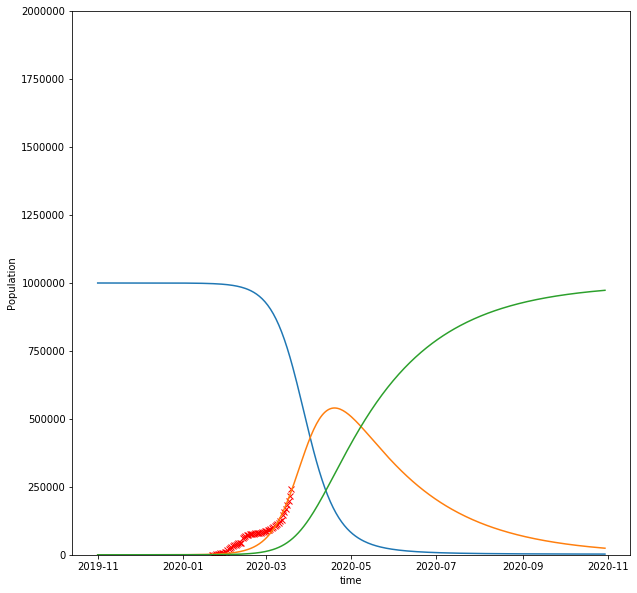

In [37]:
model = SIRmodel(np.arange(0., 365, 1), 1000000, 1, 0,
                   0.00000011, # beta how often a susceptible-infected contact results in a new infection.
                   0.018, # gamma rate an infected recovers and moves into the resistant phase
                   returnDataFrame=True, plotFig=False)

fig, axes = plt.subplots(1,1, figsize=(10,10))
axes.set_xlabel('time')
axes.set_ylabel('Population')

axes.plot(COVID19_totalConf, 'rx')
axes.plot(model) 
axes.set_ylim([0, 2000000]);

# Case of 500k infected people

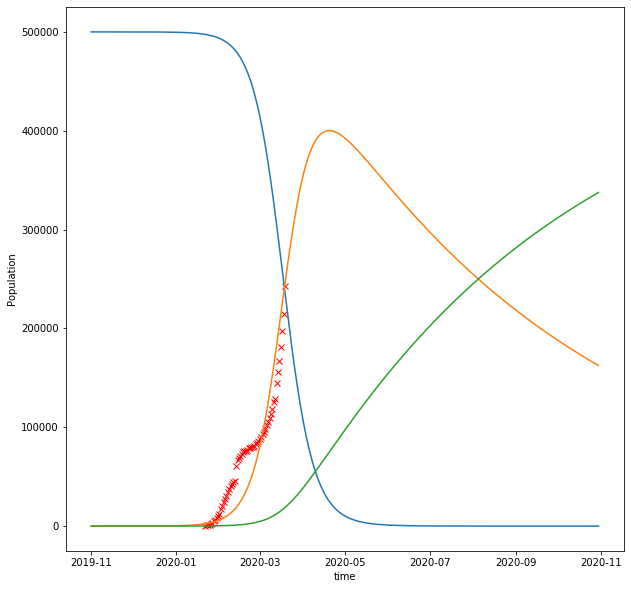

In [52]:
model = SIRmodel(np.arange(0., 365, 1), 500000, 1, 0,
                   0.0000002, # beta how often a susceptible-infected contact results in a new infection.
                   0.005, # gamma rate an infected recovers and moves into the resistant phase
                   returnDataFrame=True,
                plotFig=False)

fig, axes = plt.subplots(1,1, figsize=(10,10))
axes.set_xlabel('time')
axes.set_ylabel('Population')

axes.plot(COVID19_totalConf, 'rx')
axes.plot(model);
# axes.set_ylim([0, 300000]);

# Playground

In [55]:
np.log10(1e-7)

-7.0

In [58]:
10**(-7)

1e-07

In [73]:
def SIRmodel_logbeta(tijdstappen, S_0, I_0, R_0, log10_beta, gamma, returnDataFrame=True, plotFig=True):
    """
    Modelimplementatie van het populatiemodel 
    
    Parameters
    -----------
    tijdstappen : np.array
        array van tijdstappen          
    """
    modeloutput = odeint(model_afgeleiden, [S_0, I_0, R_0], tijdstappen, args=(10**(log10_beta), gamma));
    modeloutput = pd.DataFrame(modeloutput, columns=['S','I','R'], index=tijdstappen)
    
    modeloutput.index = pd.date_range(start='11/1/2019', periods=len(tijdstappen))
    
    if plotFig:
        fig, axes = plt.subplots(1,1, figsize=(10,10))
        axes.set_xlabel('time')
        axes.set_ylabel('Population')

        axes.plot(COVID19_totalConf, 'rx')
        axes.plot(modeloutput);
#         modeloutput.plot()
        
    if returnDataFrame:
        return modeloutput 

In [87]:
# fig, axes = plt.subplots(1,1)
# axes.set_xlabel('time')
# axes.set_ylabel('Population')

interact(SIRmodel_logbeta, 
         tijdstappen=fixed(np.arange(0., 1000, 1)), 
         COVID19_totalConf=COVID19_totalConf,
                   S_0=FloatSlider(value=2*COVID19_totalConf.max()[0], 
                                   min=1.5*COVID19_totalConf.max()[0], 
                                   max=5000000, 
                                   step=100000,
                                   continuous_update=False, readout_format='.2e'), 
                   I_0=fixed(1), R_0=fixed(0),
                   log10_beta=FloatSlider(value=-5, min=-8, max=-4, step=0.01,
                                    continuous_update=True, readout_format='.2e'),
                   gamma=FloatSlider(value=0.01, min=0, max=0.05, step=0.001,
                                     continuous_update=False, readout_format='.2e'),
                   returnDataFrame=fixed(False));
# axes.plot(COVID19_totalConf, 'rx')

interactive(children=(FloatSlider(value=485416.0, continuous_update=False, description='S_0', max=5000000.0, m…

# Cases in Italy (source https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d)

In [8]:
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

In [9]:
url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df = pd.read_csv(url)

In [10]:
df.set_index('data').head()

,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
data,,,,,,,,,,,
2020-02-24 18:00:00,ITA,101,26,127,94,221,221,1,7,229,4324
2020-02-25 18:00:00,ITA,114,35,150,162,311,90,1,10,322,8623
2020-02-26 18:00:00,ITA,128,36,164,221,385,74,3,12,400,9587
2020-02-27 18:00:00,ITA,248,56,304,284,588,203,45,17,650,12014
2020-02-28 18:00:00,ITA,345,64,409,412,821,233,46,21,888,15695


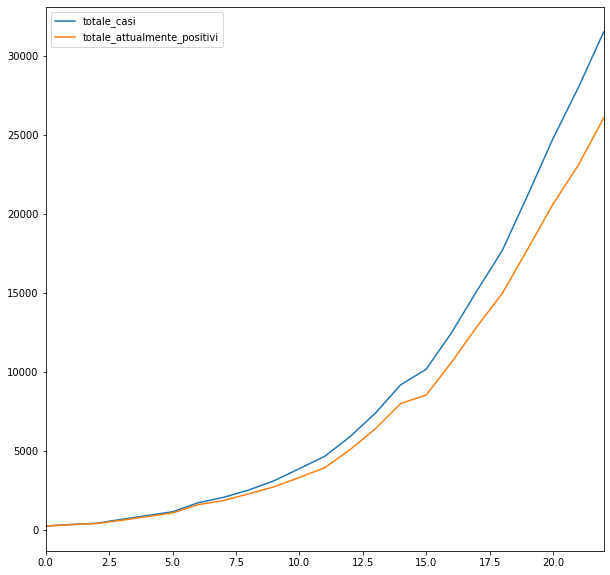

In [11]:
df[['totale_casi', 'totale_attualmente_positivi']].plot(figsize=(10,10));

In [12]:
dfn = df.loc[:,['data','totale_casi']]
FMT = '%Y-%m-%d %H:%M:%S'
date = dfn['data']
dfn['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01 00:00:00", FMT)).days  )

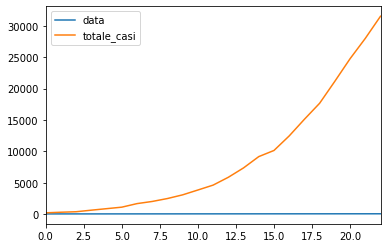

In [13]:
dfn.plot()

In [14]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

In [15]:
x = list(dfn.iloc[:,0])
y = list(dfn.iloc[:,1])
fit = curve_fit(logistic_model,x,y,p0=[2,100,20000])

In [16]:
a = fit[0][0]
b = fit[0][1]
c = fit[0][2]
print('Coeff is '+str(round(a)))
print('Coeff is '+str(round(b)))
print('Total predicted infected '+str(round(c)))

Coeff is 4.0
Coeff is 76.0
Total predicted infected 64710.0


In [17]:
errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]

In [18]:
errors

[0.08876021836129289, 0.4222000402696503, 3393.7358006918475]

In [19]:
sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))
print('Infected peak is on '+ str(pd.to_datetime(df['data'][0]) + pd.to_timedelta(sol, unit='D')))

Infected peak is on 2020-07-03 18:00:00


In [40]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

In [41]:
exp_fit = curve_fit(exponential_model,x,y,p0=[1,1,1])

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

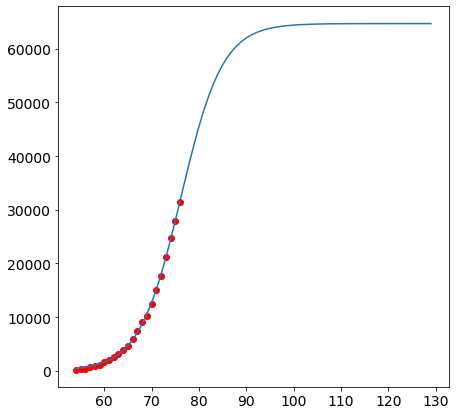

In [20]:
pred_x = list(range(max(x),sol))
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)
# Real data
plt.scatter(x,y,label="Real data",color="red")
# Predicted logistic curve
plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic model" );

# # Predicted exponential curve
# plt.plot(x+pred_x, [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in x+pred_x], label="Exponential model" )
# plt.legend()
# plt.xlabel("Days since 1 January 2020")
# plt.ylabel("Total number of infected people")
# plt.ylim((min(y)*0.9,c*1.1))
# plt.show()